In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import feature_selection

from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn.externals import joblib
from rfpimp import *

#import seaborn as sns
from sqlalchemy import create_engine

model_path = os.path.join('./models_trained')
if not os.path.isdir(model_path):
    os.makedirs(model_path)

import pandas as pd
%matplotlib inline    

In [2]:
font = {'family'        : 'sans-serif',
        'sans-serif'    : ['Computer Modern Sans serif'],
        'weight'        : 'regular',
        'size'          : 12}

text = {'usetex'        : False}

plt.rc('font', **font)
plt.rc('text', **text)

In [3]:
engine = create_engine('sqlite:///../RBpipeline/newrbogus22-dev.db')

In [4]:
dt_zps = pd.merge(pd.read_sql_table('Detected', engine),
                  pd.read_sql_query("""SELECT 
                                        Detected.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.r_scales as r_scales,
                                        Simulated.gx_mag as gx_mag,
                                        Simulated.id as sim_id 
                                    FROM Detected
                                        LEFT JOIN Reals
                                            ON Detected.id==Reals.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==Reals.simulated_id""", engine),
                                      on='id', suffixes=('',''))

dt_sps = pd.merge(pd.read_sql_table('SDetected', engine),
                  pd.read_sql_query("""SELECT 
                                        SDetected.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.r_scales as r_scales,
                                        Simulated.gx_mag as gx_mag,
                                        Simulated.id as sim_id 
                                    FROM SDetected
                                        LEFT JOIN SReals
                                            ON SDetected.id==SReals.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==SReals.simulated_id""", engine),
                                      on='id', suffixes=('',''))

dt_ois = pd.merge(pd.read_sql_table('DetectedOIS', engine),
                  pd.read_sql_query("""SELECT 
                                        DetectedOIS.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.r_scales as r_scales,
                                        Simulated.gx_mag as gx_mag,
                                        Simulated.id as sim_id 
                                    FROM DetectedOIS
                                        LEFT JOIN RealsOIS
                                            ON DetectedOIS.id==RealsOIS.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==RealsOIS.simulated_id""", engine),
                                      on='id', suffixes=('',''))

dt_hot = pd.merge(pd.read_sql_table('DetectedHOT', engine),
                  pd.read_sql_query("""SELECT 
                                        DetectedHOT.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.r_scales as r_scales,
                                        Simulated.gx_mag as gx_mag, 
                                        Simulated.id as sim_id 
                                    FROM DetectedHOT
                                        LEFT JOIN RealsHOT
                                            ON DetectedHOT.id==RealsHOT.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==RealsHOT.simulated_id""", engine),
                                      on='id', suffixes=('',''))

In [5]:
dt_ois['MAG'] = dt_ois['MAG_APER'] + 5.85970803911
dt_zps['MAG'] = dt_zps['MAG_APER'] + 0.952890475192
dt_hot['MAG'] = dt_hot['MAG_APER'] + 5.87511186008
dt_sps['MAG'] = -2.5*np.log10(dt_sps['cflux']) + 19.4029230795

In [6]:
dt_ois['MU'] = dt_ois.MAG/(dt_ois.A_IMAGE*dt_ois.B_IMAGE)
dt_zps['MU'] = dt_zps.MAG/(dt_zps.A_IMAGE*dt_zps.B_IMAGE)
dt_hot['MU'] = dt_hot.MAG/(dt_hot.A_IMAGE*dt_hot.B_IMAGE)
dt_sps['MU'] = dt_sps.MAG/(dt_sps.a*dt_sps.b)

In [7]:
dt_ois['SN'] = dt_ois.FLUX_APER/dt_ois.FLUXERR_APER
dt_zps['SN'] = dt_zps.FLUX_APER/dt_zps.FLUXERR_APER
dt_hot['SN'] = dt_hot.FLUX_APER/dt_hot.FLUXERR_APER
dt_sps['SN'] = dt_sps.cflux/np.sqrt(dt_sps.cflux)

In [8]:
dt_ois.IS_REAL = dt_ois.IS_REAL.astype(int)
dt_zps.IS_REAL = dt_zps.IS_REAL.astype(int)
dt_hot.IS_REAL = dt_hot.IS_REAL.astype(int)
dt_sps.IS_REAL = dt_sps.IS_REAL.astype(int)

In [9]:
d_ois = dt_ois[[ u'FLUX_ISO', u'FLUXERR_ISO', u'MAG_ISO',
       u'MAGERR_ISO', u'FLUX_APER', u'FLUXERR_APER', u'MAG_APER',
       u'MAGERR_APER', u'FLUX_AUTO', u'FLUXERR_AUTO', u'MAG_AUTO',
       u'MAGERR_AUTO', u'BACKGROUND', u'THRESHOLD', u'FLUX_MAX', u'X2_IMAGE', u'Y2_IMAGE',
       u'XY_IMAGE', u'CXX_IMAGE', u'CYY_IMAGE', u'CXY_IMAGE', u'A_IMAGE',
       u'B_IMAGE', u'THETA_IMAGE', u'MU_MAX', u'FLAGS', u'FWHM_IMAGE',
       u'ELONGATION', u'ELLIPTICITY', u'CLASS_STAR', u'DELTAX', u'DELTAY',
       u'RATIO', u'ROUNDNESS', u'PEAK_CENTROID', 'MAG', 'MU', 'SN']]

In [10]:
d_zps = dt_zps[[ u'FLUX_ISO', u'FLUXERR_ISO', u'MAG_ISO',
       u'MAGERR_ISO', u'FLUX_APER', u'FLUXERR_APER', u'MAG_APER',
       u'MAGERR_APER', u'FLUX_AUTO', u'FLUXERR_AUTO', u'MAG_AUTO',
       u'MAGERR_AUTO', u'BACKGROUND', u'THRESHOLD', u'FLUX_MAX', u'X2_IMAGE', u'Y2_IMAGE',
       u'XY_IMAGE', u'CXX_IMAGE', u'CYY_IMAGE', u'CXY_IMAGE', u'A_IMAGE',
       u'B_IMAGE', u'THETA_IMAGE', u'MU_MAX', u'FLAGS', u'FWHM_IMAGE',
       u'ELONGATION', u'ELLIPTICITY', u'CLASS_STAR', u'DELTAX', u'DELTAY',
       u'RATIO', u'ROUNDNESS', u'PEAK_CENTROID', 'MAG', 'MU', 'SN']]

In [11]:
d_hot = dt_hot[[ u'FLUX_ISO', u'FLUXERR_ISO', u'MAG_ISO',
       u'MAGERR_ISO', u'FLUX_APER', u'FLUXERR_APER', u'MAG_APER',
       u'MAGERR_APER', u'FLUX_AUTO', u'FLUXERR_AUTO', u'MAG_AUTO',
       u'MAGERR_AUTO', u'BACKGROUND', u'THRESHOLD', u'FLUX_MAX', u'X2_IMAGE', u'Y2_IMAGE',
       u'XY_IMAGE', u'CXX_IMAGE', u'CYY_IMAGE', u'CXY_IMAGE', u'A_IMAGE',
       u'B_IMAGE', u'THETA_IMAGE', u'MU_MAX', u'FLAGS', u'FWHM_IMAGE',
       u'ELONGATION', u'ELLIPTICITY', u'CLASS_STAR', u'DELTAX', u'DELTAY',
       u'RATIO', u'ROUNDNESS', u'PEAK_CENTROID', 'MAG', 'MU', 'SN']]

In [12]:
d_sps = dt_sps[[u'thresh', u'npix', u'tnpix', u'xmin', u'xmax', u'ymin', u'ymax', u'x', u'y', u'x2', u'y2',
                  u'xy', u'errx2', u'erry2', u'errxy', u'a', u'b', u'theta', u'cxx', u'cyy', u'cxy', u'cflux',          u'flux',
               u'cpeak', u'peak', u'xcpeak', u'ycpeak', u'xpeak', u'ypeak', u'flag', u'DELTAX',
              u'DELTAY', u'RATIO', u'ROUNDNESS', u'PEAK_CENTROID', u'MAG', u'MU', u'SN']]

In [13]:
X_zps = d_zps.as_matrix()
X_ois = d_ois.as_matrix()
X_hot = d_hot.as_matrix()
X_sps = d_sps.as_matrix()

In [14]:
scaler_ois = preprocessing.StandardScaler().fit(X_ois)
scaler_zps = preprocessing.StandardScaler().fit(X_zps)
scaler_hot = preprocessing.StandardScaler().fit(X_hot)
scaler_sps = preprocessing.StandardScaler().fit(X_sps)

In [15]:
X_ois_scaled = scaler_ois.transform(X_ois)
X_zps_scaled = scaler_zps.transform(X_zps)
X_hot_scaled = scaler_hot.transform(X_hot)
X_sps_scaled = scaler_sps.transform(X_sps)

In [16]:
Y_sps = dt_sps['IS_REAL']
Y_ois = dt_ois['IS_REAL']
Y_zps = dt_zps['IS_REAL']
Y_hot = dt_hot['IS_REAL']

In [17]:
type(Y_zps)

pandas.core.series.Series

In [18]:
from sklearn.ensemble import ExtraTreesClassifier

In [20]:
def importance_forest(X, y, forest, cols=None, method=None):
    forest = ExtraTreesClassifier(n_estimators=250,
                                  random_state=0)
    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    #print indices 
    #print importances
    #print cols
    # Print the feature ranking
    #print("Feature ranking:")

    if cols is not None:
        f = 0
        for ind in indices:
            #print("%d. feature %s (%f)" % (f + 1, cols[ind-1], importances[ind-1]))
            f += 1
    else:
        f = 0
        for ind in indices:
            #print("%d. feature %d (%f)" % (f + 1, ind, importances[ind]))
            f += 1

    # Plot the feature importances of the forest
    #plt.figure(figsize=(6, 6))
    plt.title("{}".format(method))
    plt.barh(range(X.shape[1])[0:8], importances[indices][0:8], 
           color="r", xerr=std[indices][0:8], align="center")
    if cols is not None:
        plt.yticks(range(X.shape[1])[0:8], cols[indices-1][0:8], rotation='horizontal', fontsize=10)
    else:
        plt.yticks(range(X.shape[1]), indices)
    #plt.ylim([-1, X.shape[1]])
    plt.xlim(0, np.max(importances)+np.max(std))
    ax = plt.gca()
    ax.invert_yaxis() 
    #plt.show()
    return [(cols[indices[f]-1], importances[indices[f]]) for f in range(X.shape[1])]

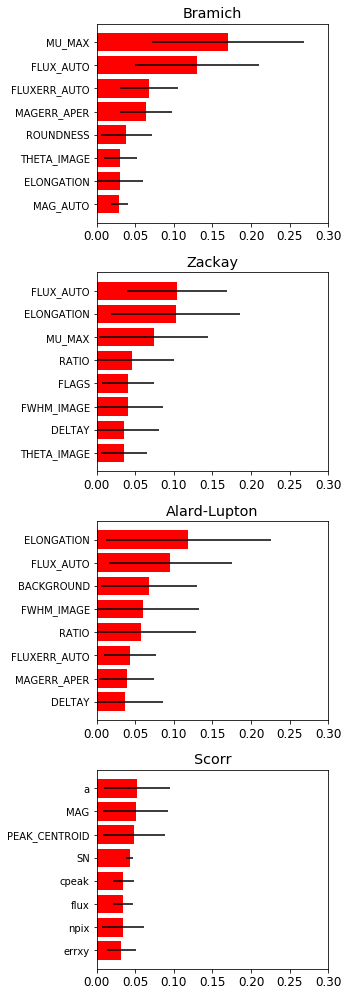

In [24]:
plt.figure(figsize=(5, 14))
plt.subplot(411)
ois_importance = importance_forest(X_ois_scaled, Y_ois, ExtraTreesClassifier(n_estimators=400, random_state=0), 
                 cols=d_ois.columns, method='Bramich')
plt.xlim(0, 0.3)
plt.subplot(412)
zps_importance = importance_forest(X_zps_scaled, Y_zps, ExtraTreesClassifier(n_estimators=400, random_state=0), 
                                   cols=d_zps.columns, method='Zackay')
plt.xlim(0, 0.3)
plt.subplot(413)
hot_importance = importance_forest(X_hot_scaled, Y_hot, ExtraTreesClassifier(n_estimators=400, random_state=0), 
                                   cols=d_hot.columns, method='Alard-Lupton')
plt.xlim(0, 0.3)
plt.subplot(414)
sps_importance = importance_forest(X_sps_scaled, Y_sps, ExtraTreesClassifier(n_estimators=400, random_state=0), 
                                   cols=d_sps.columns, method='Scorr')
plt.xlim(0, 0.3)
plt.tight_layout()

In [27]:
def full_importance_forest(X, y, forest=None, cols=None, method=None):
    if forest is None:
        forest = ExtraTreesClassifier(n_estimators=250,
                                  random_state=0)
    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    
    return [indices, importances, cols]

In [30]:
ois_importance = full_importance_forest(X_ois_scaled, Y_ois, ExtraTreesClassifier(n_estimators=400, random_state=0), 
                 cols=d_ois.columns, method='Bramich')
zps_importance = full_importance_forest(X_zps_scaled, Y_zps, ExtraTreesClassifier(n_estimators=400, random_state=0), 
                                   cols=d_zps.columns, method='Zackay')
hot_importance = full_importance_forest(X_hot_scaled, Y_hot, ExtraTreesClassifier(n_estimators=400, random_state=0), 
                                   cols=d_hot.columns, method='Alard-Lupton')
sps_importance = full_importance_forest(X_sps_scaled, Y_sps, ExtraTreesClassifier(n_estimators=400, random_state=0), 
                                   cols=d_sps.columns, method='Scorr')

In [35]:
ois_importance


[array([25,  9, 10,  8, 34, 24, 28, 11, 22, 32, 14,  2,  1, 36,  3, 19, 37,
        26,  4, 18,  6,  5,  7, 35, 21, 15,  0, 16, 30, 31, 33, 27, 13, 20,
        17, 12, 23, 29]),
 array([ 0.0128247 ,  0.0227798 ,  0.0255853 ,  0.02167637,  0.01746134,
         0.01492094,  0.01610981,  0.01480998,  0.06385336,  0.13019129,
         0.0674485 ,  0.02915451,  0.00425642,  0.00713622,  0.02580834,
         0.01283017,  0.01224538,  0.00427516,  0.01680578,  0.0208123 ,
         0.00587162,  0.0129909 ,  0.02723929,  0.00382368,  0.03063979,
         0.17027826,  0.01824907,  0.00887929,  0.02996279,  0.00266752,
         0.00933784,  0.00915099,  0.02617632,  0.00897025,  0.03858275,
         0.01471958,  0.02236132,  0.01911307]),
 Index([     u'FLUX_ISO',   u'FLUXERR_ISO',       u'MAG_ISO',    u'MAGERR_ISO',
            u'FLUX_APER',  u'FLUXERR_APER',      u'MAG_APER',   u'MAGERR_APER',
            u'FLUX_AUTO',  u'FLUXERR_AUTO',      u'MAG_AUTO',   u'MAGERR_AUTO',
           u'BACKGROUN

In [37]:
len(ois_importance[1])

38

In [39]:
mat = np.empty((3, 38))

In [40]:
mat[0, :] = ois_importance[1]
mat[1, :] = zps_importance[1]
mat[2, :] = sps_importance[1]

In [52]:
names  = []
for aname in ois_importance[2]:
    names.append(aname)

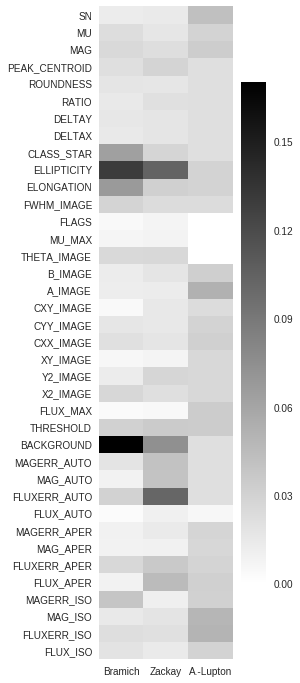

In [77]:
plt.figure(figsize=(3, 12))
sns.heatmap(mat.T, cmap='gray_r')

plt.yticks(np.arange(38)+0.5,names, rotation='horizontal')
plt.xticks(np.arange(3)+0.5, ['Bramich', 'Zackay', 'A.-Lupton'])
#plt.colorbar()
plt.show()

In [68]:
sps_importance[2]

Index([       u'thresh',          u'npix',         u'tnpix',          u'xmin',
                u'xmax',          u'ymin',          u'ymax',             u'x',
                   u'y',            u'x2',            u'y2',            u'xy',
               u'errx2',         u'erry2',         u'errxy',             u'a',
                   u'b',         u'theta',           u'cxx',           u'cyy',
                 u'cxy',         u'cflux',          u'flux',         u'cpeak',
                u'peak',        u'xcpeak',        u'ycpeak',         u'xpeak',
               u'ypeak',          u'flag',        u'DELTAX',        u'DELTAY',
               u'RATIO',     u'ROUNDNESS', u'PEAK_CENTROID',           u'MAG',
                  u'MU',            u'SN'],
      dtype='object')

## Importances with permutation

In [266]:
def importance_perm(X, y, forest=None, cols=None, method=None):
    
    X = pd.DataFrame(X, columns=cols)
    y = pd.DataFrame(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    
    if forest is None:
        forest = RandomForestClassifier(n_estimators=250, random_state=33, n_jobs=-1)
    
    X_train['Random'] = np.random.random(size=len(X_train))
    X_test['Random'] = np.random.random(size=len(X_test))
    
    forest.fit(X_train, y_train)
    imp = importances(forest, X_test, y_test) # permutation
    return imp

In [267]:
ois_importance = importance_perm(X_ois_scaled, Y_ois, RandomForestClassifier(n_estimators=400, random_state=0), 
                                   cols=d_ois.columns, method='Bramich')
zps_importance = importance_perm(X_zps_scaled, Y_zps, RandomForestClassifier(n_estimators=400, random_state=0), 
                                   cols=d_zps.columns, method='Zackay')
hot_importance = importance_perm(X_hot_scaled, Y_hot, RandomForestClassifier(n_estimators=400, random_state=0), 
                                   cols=d_hot.columns, method='Alard-Lupton')
sps_importance = importance_perm(X_sps_scaled, Y_sps, RandomForestClassifier(n_estimators=400, random_state=0), 
                                   cols=d_sps.columns, method='Scorr')

/home/bruno/.virtualenvs/daily/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/bruno/.virtualenvs/daily/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/bruno/.virtualenvs/daily/lib/python2.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

In [268]:
d_sps.columns

Index([       u'thresh',          u'npix',         u'tnpix',          u'xmin',
                u'xmax',          u'ymin',          u'ymax',             u'x',
                   u'y',            u'x2',            u'y2',            u'xy',
               u'errx2',         u'erry2',         u'errxy',             u'a',
                   u'b',         u'theta',           u'cxx',           u'cyy',
                 u'cxy',         u'cflux',          u'flux',         u'cpeak',
                u'peak',        u'xcpeak',        u'ycpeak',         u'xpeak',
               u'ypeak',          u'flag',        u'DELTAX',        u'DELTAY',
               u'RATIO',     u'ROUNDNESS', u'PEAK_CENTROID',           u'MAG',
                  u'MU',            u'SN'],
      dtype='object')

In [19]:
transl = {u'thresh': u'THRESHOLD', 
          u'peak': u'FLUX_MAX',
          u'x2': u'X2_IMAGE', 
          u'y2': u'Y2_IMAGE',
          u'xy': u'XY_IMAGE',
          u'a':u'A_IMAGE',
          u'b':u'B_IMAGE',
          u'theta':u'THETA_IMAGE',
          u'cxx':u'CXX_IMAGE',
          u'cyy':u'CYY_IMAGE',
          u'cxy':u'CXY_IMAGE',
          u'cflux':u'FLUX_ISO',
          u'flux':u'FLUX_APER',
          u'flag': u'FLAGS',
          u'DELTAX': u'DELTAX',
          u'DELTAY': u'DELTAY',
          u'RATIO': u'RATIO',
          u'ROUNDNESS': u'ROUNDNESS',
          u'PEAK_CENTROID': u'PEAK_CENTROID',
          u'MAG': u'MAG',
          u'MU': u'MU',
          u'SN': u'SN'}

In [20]:
detransl = {v: k for k, v in transl.iteritems()}

In [21]:
complement = []
for v in d_sps.columns:
    if v not in detransl.values():
        complement.append(v)

In [22]:
sps_importance = sps_importance.rename(index=transl)

NameError: name 'sps_importance' is not defined

In [23]:
cols = d_ois.columns

In [24]:
newcols = list(cols.values)
newcols.extend(complement)
newcols.extend(['Random'])

In [275]:
m = pd.concat([ois_importance, zps_importance, hot_importance, sps_importance], axis=1)

In [276]:
m = m.reindex(newcols)

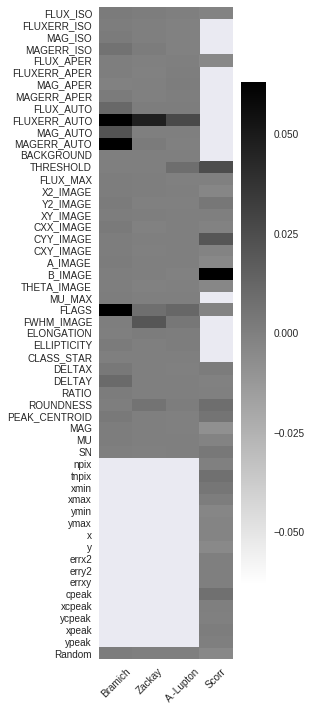

In [277]:
plt.figure(figsize=(3, 12))
sns.heatmap(m, robust=True, cmap='gray_r')

plt.yticks(np.arange(len(m))+0.5, rotation='horizontal')
plt.xticks(np.arange(4)+0.5, ['Bramich', 'Zackay', 'A.-Lupton', 'Scorr'], rotation=45)
#plt.colorbar()
plt.show()

## Trying Stratified K-Fold cross validation

In [25]:
def importance_perm_kfold(X, y, forest=None, cols=None, method=None, nfolds=10):
    skf = StratifiedKFold(n_splits=nfolds)
    imp = []

    for train, test in skf.split(X, y):      
        X_train = pd.DataFrame(X[train], columns=cols)
        X_test = pd.DataFrame(X[test], columns=cols)
        y_train = pd.DataFrame(y[train])
        y_test = pd.DataFrame(y[test])
        
        if forest is None:
            forest = RandomForestClassifier(n_estimators=250, random_state=33, n_jobs=-1)

        X_train['Random'] = np.random.random(size=len(X_train))
        X_test['Random'] = np.random.random(size=len(X_test))

        forest.fit(X_train, y_train)
        imp.append(importances(forest, X_test, y_test)) # permutation
    #imp = pd.concat(imp, axis=1)
    return imp

In [26]:
ois_importance = importance_perm_kfold(X_ois_scaled, Y_ois, RandomForestClassifier(n_estimators=400, random_state=0), 
                                   cols=d_ois.columns, method='Bramich')
zps_importance = importance_perm_kfold(X_zps_scaled, Y_zps, RandomForestClassifier(n_estimators=400, random_state=0), 
                                   cols=d_zps.columns, method='Zackay')
hot_importance = importance_perm_kfold(X_hot_scaled, Y_hot, RandomForestClassifier(n_estimators=400, random_state=0), 
                                   cols=d_hot.columns, method='Alard-Lupton')
sps_importance = importance_perm_kfold(X_sps_scaled, Y_sps, RandomForestClassifier(n_estimators=400, random_state=0), 
                                   cols=d_sps.columns, method='Scorr')

/home/bruno/.virtualenvs/daily/lib/python2.7/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [27]:
sps_newimp = []
for animp in sps_importance:
    sps_newimp.append(animp.rename(index=transl))

In [28]:
res_ois = pd.concat(ois_importance, axis=1)
res_zps = pd.concat(zps_importance, axis=1)
res_hot = pd.concat(hot_importance, axis=1)
res_sps = pd.concat(sps_newimp, axis=1)

In [29]:
res_ois.mean(axis=1)

A_IMAGE         -6.637111e-04
BACKGROUND       3.443467e-08
B_IMAGE         -4.562250e-04
CLASS_STAR      -1.244641e-04
CXX_IMAGE       -2.074345e-04
CXY_IMAGE       -3.317609e-04
CYY_IMAGE       -8.291870e-05
DELTAX           3.235671e-03
DELTAY           6.637645e-03
ELLIPTICITY      2.904048e-04
ELONGATION      -4.147312e-04
FLAGS            1.154536e-01
FLUXERR_APER     7.884163e-04
FLUXERR_AUTO     1.236270e-01
FLUXERR_ISO     -3.317781e-04
FLUX_APER       -6.222173e-04
FLUX_AUTO        1.555779e-02
FLUX_ISO        -4.148001e-04
FLUX_MAX         4.564488e-04
FWHM_IMAGE       9.126566e-04
MAG             -2.074861e-04
MAGERR_APER     -2.073828e-04
MAGERR_AUTO      6.343129e-02
MAGERR_ISO       2.240544e-03
MAG_APER        -1.719590e-08
MAG_AUTO         1.605586e-02
MAG_ISO         -4.154545e-05
MU              -2.489799e-04
MU_MAX           9.959024e-04
PEAK_CENTROID    4.273085e-03
RATIO            2.074345e-03
ROUNDNESS        2.905253e-04
Random          -4.144213e-05
SN        

In [30]:
m = pd.concat([res_ois.mean(axis=1), res_zps.mean(axis=1), res_hot.mean(axis=1), res_sps.mean(axis=1)], axis=1)

In [31]:
m = m.reindex(newcols)

In [32]:
s = pd.concat([res_ois.std(axis=1), res_zps.std(axis=1), res_hot.std(axis=1), res_sps.std(axis=1)], axis=1)

In [33]:
s = s.reindex(newcols)

In [34]:
for i in range(4):
    m[i] = m[i] - m[i]['Random']
    m[i] = m[i]/np.max(m[i])

In [36]:
np.min(m), np.max(m)

(0   -0.005032
 1    0.000000
 2   -0.008682
 3   -0.025034
 dtype: float64, 0    1.0
 1    1.0
 2    1.0
 3    1.0
 dtype: float64)

In [37]:
m2 = m.copy()

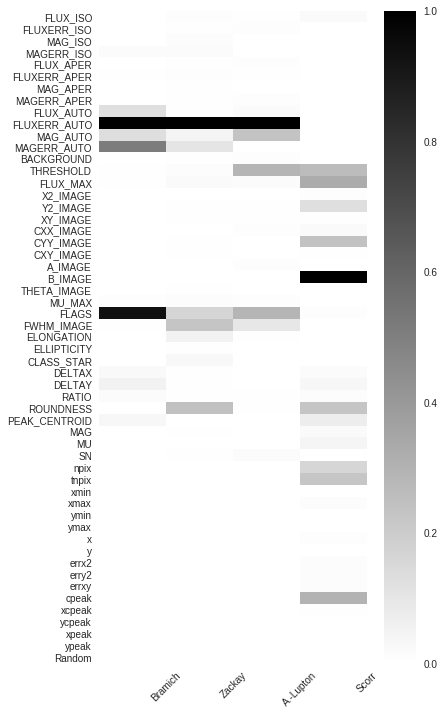

In [47]:
plt.figure(figsize=(6, 12))
plt.imshow(m2.fillna(0).as_matrix(), vmin=0, vmax=1., cmap='gray_r', aspect='auto')
plt.yticks(np.arange(len(m)), m.index, rotation='horizontal')
plt.xticks(np.arange(4)+0.5, ['Bramich', 'Zackay', 'A.-Lupton', 'Scorr'], rotation=45)
plt.grid()
plt.colorbar()
plt.savefig('./feature_heatmap_simdata.svg',  bbox_inches='tight')

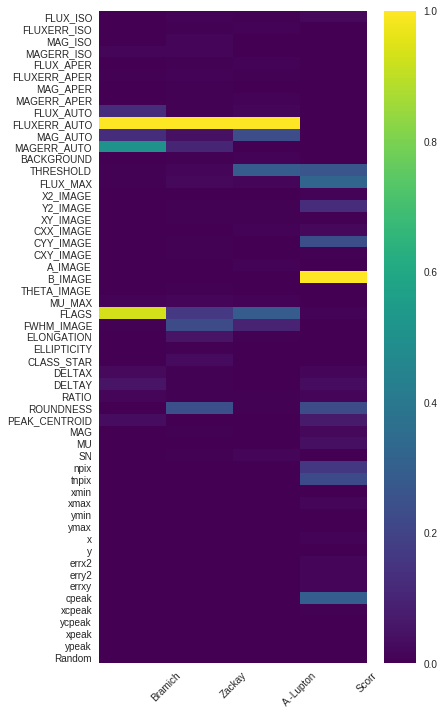

In [48]:
plt.figure(figsize=(6, 12))
plt.imshow(m2.fillna(0).as_matrix(), vmin=0, vmax=1., cmap='viridis', aspect='auto')
plt.yticks(np.arange(len(m)), m.index, rotation='horizontal')
plt.xticks(np.arange(4)+0.5, ['Bramich', 'Zackay', 'A.-Lupton', 'Scorr'], rotation=45)
plt.grid()
plt.colorbar()
plt.savefig('./feature_heatmap_simdata_color.svg',  bbox_inches='tight')

In [40]:
import seaborn as sns

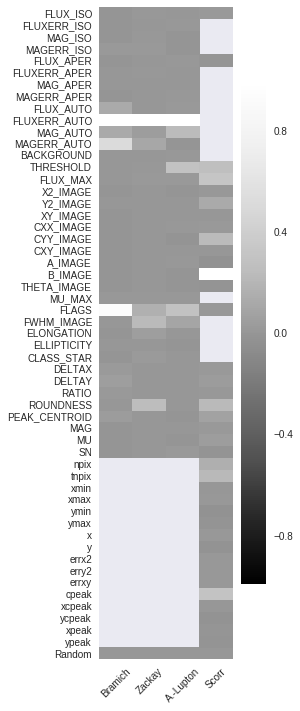

In [41]:
plt.figure(figsize=(3, 12))
sns.heatmap(m, robust=True, cmap='Greys_r')

plt.yticks(np.arange(len(m))+0.5, rotation='horizontal')
plt.xticks(np.arange(4)+0.5, ['Bramich', 'Zackay', 'A.-Lupton', 'Scorr'], rotation=45)
#plt.colorbar()
plt.savefig('./feature_heatmap_simdata.pdf', bbox_inches='tight')

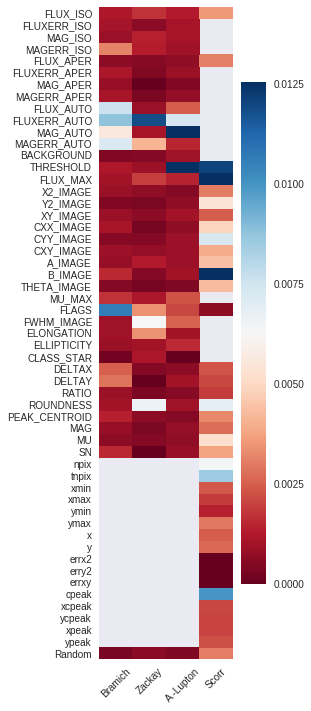

In [42]:
plt.figure(figsize=(3, 12))
sns.heatmap(s, robust=True, cmap='RdBu')

plt.yticks(np.arange(len(s))+0.5, rotation='horizontal')
plt.xticks(np.arange(4)+0.5, ['Bramich', 'Zackay', 'A.-Lupton', 'Scorr'], rotation=45)
#plt.colorbar()
plt.show()

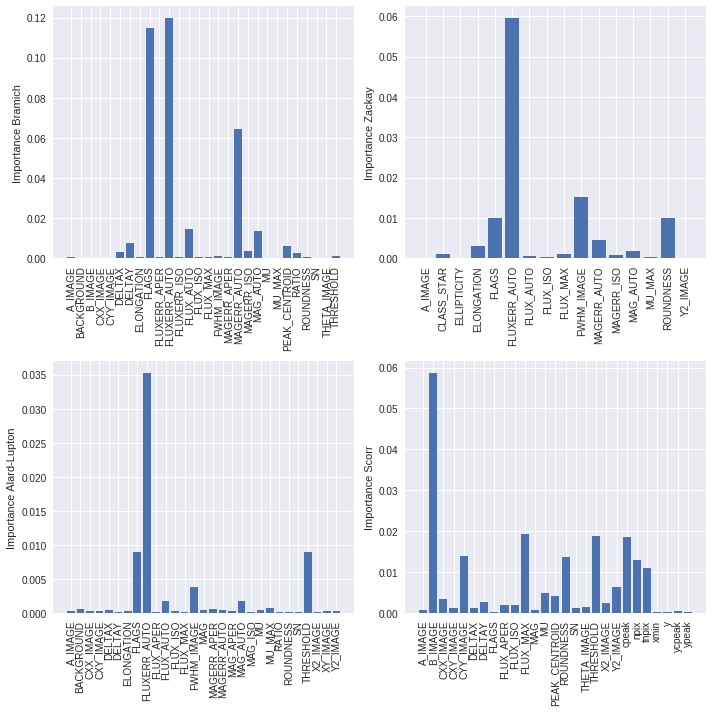

In [333]:
plt.figure(figsize=(10, 10))
plt.subplot(221)
selected_ois = m[0][m[0] > m.loc['Random'][0]]
plt.bar(selected_ois.index, selected_ois.values)
plt.xticks(rotation='vertical')
plt.ylabel('Importance Bramich')
#plt.xticks(np.arange(len(selected_ois.index)), selected_ois.index, rotation=45)

plt.subplot(222)
selected_zps = m[1][m[1] > m.loc['Random'][1]]
plt.bar(selected_zps.index, selected_zps.values)
plt.xticks(rotation='vertical')
plt.ylabel('Importance Zackay')

plt.subplot(223)
selected_hot = m[2][m[2] > m.loc['Random'][2]]
plt.bar(selected_hot.index, selected_hot.values)
plt.xticks(rotation='vertical')
plt.ylabel('Importance Alard-Lupton')

plt.subplot(224)
selected_sps = m[3][m[3] > m.loc['Random'][3]]
plt.bar(selected_sps.index, selected_sps.values)
plt.xticks(rotation='vertical')
plt.ylabel('Importance Scorr')

plt.tight_layout()